In [1]:
!pip install stanza

     |████████████████████████████████| 337 kB 5.4 MB/s 


In [2]:
!pip install sacrebleu

     |████████████████████████████████| 54 kB 1.6 MB/s 


In [3]:
import re
import TER
import stanza
import string
import argparse
import sacrebleu
import TER_modified
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk import word_tokenize

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!git clone https://github.com/mahfuzibnalam/terminology_evaluation.git
!cd terminology_evaluation; pip install -r requirements.txt

fatal: destination path 'terminology_evaluation' already exists and is not an empty directory.


## Read files

In [5]:
# read target and source files
SUPPORTED = True
def read_reference_data_wmt(lt, ls):
	with open(lt, encoding="utf-8") as inp:
		linest = inp.readlines()
	with open(ls, encoding="utf-8") as inp:
		liness = inp.readlines()

	refs = {}
	outputs = []
	for idx in range(len(liness)):
		linet = linest[idx]
		lines = liness[idx]
		if "</seg>" in lines:
			soups = BeautifulSoup(lines, "lxml")
			soupt = BeautifulSoup(linet, "lxml")

			id = soups.seg['id']
			source_tokens = soups.text.split()
			target_tokens = soupt.text.split()

			source = " " + " ".join(source_tokens) + " "
			target = " " + " ".join(target_tokens) + " "
			outputs.append(target)

			terms = []
			terms_l = []
			mod_terms = []
			src_terms = soups.find_all('term')
			tgt_terms = soupt.find_all('term')
			for ids, item in enumerate(tgt_terms):
				src_start = source_tokens.index(src_terms[ids].text.split()[0])
				src_end = source_tokens.index(src_terms[ids].text.split()[-1])
				src_ids = ""
				for ind in range(src_start, src_end - 1):
					src_ids += (str)(ind) + ","
				src_ids += (str)(src_end)

				tgt_start = target_tokens.index(item.text.split()[0])
				tgt_end = target_tokens.index(item.text.split()[-1])
				tgt_ids = ""
				for ind in range(tgt_start, tgt_end - 1):
					tgt_ids += (str)(ind) + ","
				tgt_ids += (str)(tgt_end)

				tgt_term = item['tgt']
				if item.text.strip() not in tgt_term:
					tgt_term = item['tgt'] + "|" + item.text.strip()
				mod_terms.append(f"{src_terms[ids].text} ||| {src_ids} --> {tgt_term} ||| {tgt_ids}")

				if "tgt_original" in tgt_terms[ids]['type']:
					terms.append(f"{src_terms[ids].text} ||| {src_ids} --> {tgt_terms[ids].text} ||| {tgt_ids}")
				if "tgt_lemma" in tgt_terms[ids]['type']:
					if SUPPORTED:
						doc_f = l2_stanza(tgt_terms[ids].text)
						tgt_lemma = ' ' + ' '.join([w.lemma for w in doc_f.sentences[0].words]) + ' '
						terms_l.append(f"{src_terms[ids].text} ||| {src_ids} --> {tgt_lemma} ||| {tgt_ids}")
      
			refs[id] = (source, target, terms, terms_l, mod_terms)

	return outputs, refs

In [6]:
# read the outputs or hypothesis
def read_outputs_wmt(f):
	with open(f) as inp:
		lines = inp.readlines()
	outputs = []
	ids = []
	for line in lines:
		if "</seg>" in line:
			soup = BeautifulSoup(line, "lxml")
			ids.append(soup.seg['id'])
			outputs.append(' ' + ' '.join(soup.seg.text.strip().split()) + ' ')
	return ids, outputs

## Exact-Match accuracy

In [7]:
def compare_EXACT(hyp, ref):
	_, _, _, _, terms = ref

	if SUPPORTED:
		doc_f = l2_stanza(hyp)
		try:
			hyp_l = ' ' + ' '.join([w.lemma for w in doc_f.sentences[0].words]) + ' '
		except:
			hyp_l = ""

	count_correct = 0
	count_wrong = 0
	count_correct_l = 0
	count_wrong_l = 0

	starts = []
	for t in terms:
		t = t.split(' --> ')
		t = t[1].split(' ||| ')
		desired_list = []
		for item in t[0].split("|"):
			desired_list.append("(?= " + item + " )")
		desireds = "|".join(desired_list)

		flag = False
		for desired in desireds.split("|"):
			desired_starts = [m.start() for m in re.finditer(desired, hyp)]
			for desired_start in desired_starts:
				if desired_start not in starts:
					starts.append(desired_start)
					flag = True
					break
		if not flag and SUPPORTED:
			flag_l = False
			for desired in desireds.split("|"):
				desired_starts = [m.start() for m in re.finditer(desired, hyp_l)]
				for desired_start in desired_starts:
					if desired_start not in starts:
						starts.append(desired_start)
						flag_l = True
						break
			if flag_l:
				count_correct_l += 1
			else:
				count_wrong += 1
		else:
			count_correct += 1

	return count_correct, count_wrong, count_correct_l, count_wrong_l
  
def exact_match(l2, references, outputs, ids):
	correct = 0
	wrong = 0
	correctl = 0
	wrongl = 0
	for i, id in enumerate(ids):
		if id in references:
			c, w, cl, wl = compare_EXACT(outputs[i], references[id])
			correct += c
			wrong += w
			correctl += cl
			wrongl += wl
	return (correct + correctl) / (correct + correctl + wrong + wrongl)
	'''print(f"Exact-Match Statistics")
	print(f"\tTotal correct: {correct}")
	print(f"\tTotal wrong: {wrong}")
	print(f"\tTotal correct (lemma): {correctl}")
	print(f"\tTotal wrong (lemma): {wrongl}")
	print(f"Exact-Match Accuracy: {(correct + correctl) / (correct + correctl + wrong + wrongl)}")'''

In [8]:
l2 ='fr'
stanza.download(l2, processors='tokenize,pos,lemma,depparse')
l2_stanza = stanza.Pipeline(processors='tokenize,pos,lemma,depparse', lang=l2, use_gpu=True, tokenize_pretokenized=True)

2021-08-04 07:45:31 INFO: Downloading these customized packages for language: fr (French)...
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |
| pretrain  | gsd     |



2021-08-04 07:46:09 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-08-04 07:46:09 INFO: Loading these models for language: fr (French):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |

2021-08-04 07:46:09 INFO: Use device: cpu
2021-08-04 07:46:09 INFO: Loading: tokenize
2021-08-04 07:46:09 INFO: Loading: pos
2021-08-04 07:46:10 INFO: Loading: lemma
2021-08-04 07:46:10 INFO: Loading: depparse
2021-08-04 07:46:11 INFO: Done loading processors!


In [ ]:
# Exact-Match accuracy Test
sentreferences, exactreferences = read_reference_data_wmt('tgt.fr', 'src.en')
ids, outputs = read_outputs_wmt('hyp.fr')
exact_match(l2, exactreferences, outputs, ids)

NameError: ignored

## Window Overlap accuracy

In [9]:
def compare_exact_window_overlap(hyp, ref, window):
	source, reference, terms, terms_l, _ = ref
	accuracy = 0.0
	matched = 0

	hyp_tokens = hyp.strip().split()
	reference_tokens = reference.strip().split()
	desireds = {}
	for t in terms:
		t = t.split(' --> ')
		t = t[1].split(' ||| ')
		desired  = " " + t[0].strip() + " "
		desiredindxs = [(int)(item)for item in t[1].split(",")]
		if desired in desireds:
			desireds[desired].append(desiredindxs)
		else:
			desireds[desired] = [desiredindxs]
	for desired in desireds:
		fts = [m.start() for m in re.finditer(f"(?={desired})", hyp)]
		accs = {}
		for j, listfs in enumerate(desireds[desired]):
			ref_words = []
			for win in range(min(listfs) - 1, -1, -1):
				if reference_tokens[win] not in string.punctuation:
					ref_words.append(reference_tokens[win])
					if len(ref_words) == window:
						break
			ref_wordsr = []
			for win in range(max(listfs) + 1, len(reference_tokens), 1):
				if reference_tokens[win] not in string.punctuation:
					ref_wordsr.append(reference_tokens[win])
					if len(ref_wordsr) == window:
						break
			ref_words.extend(ref_wordsr)
			for k, ft in enumerate(fts):
				cntfts = hyp.count(" ", 0, ft)
				listft = [item for item in range(cntfts, cntfts + len(desired.strip().split()))]
				hyp_words = []
				for win in range(min(listft) - 1, -1, -1):
					if hyp_tokens[win] not in string.punctuation:
						hyp_words.append(hyp_tokens[win])
						if len(hyp_words) == window:
							break
				hyp_wordsr = []
				for win in range(max(listft) + 1, len(hyp_tokens), 1):
					if hyp_tokens[win] not in string.punctuation:
						hyp_wordsr.append(hyp_tokens[win])
						if len(hyp_wordsr) == window:
							break
				hyp_words.extend(hyp_wordsr)
				cnt = 0
				for ref_word in ref_words:
					if ref_word in hyp_words:
						cnt += 1
						hyp_words.remove(ref_word)
				accs[f"{j}-{k}"] = cnt / len(ref_words) if len(ref_words) != 0 else + 0
		accs = dict(sorted(accs.items(), key=lambda item: item[1], reverse=True))
		mapped_ref = []
		mapped_hyp = []
		for acc in accs:
			if acc.split("-")[0] not in mapped_ref and acc.split("-")[1] not in mapped_hyp:
				mapped_ref.append(acc.split("-")[0])
				mapped_hyp.append(acc.split("-")[1])
				matched += 1
				accuracy += accs[acc]
	
	if SUPPORTED and terms_l:
		doc_f = l2_stanza(hyp)
		hyp = ' ' + ' '.join([w.lemma for w in doc_f.sentences[0].words]) + ' '
		doc_f = l2_stanza(reference)
		reference = ' ' + ' '.join([w.lemma for w in doc_f.sentences[0].words]) + ' '
		hyp_tokens = hyp.strip().split()
		reference_tokens = reference.strip().split()
		desireds = {}
		for t in terms_l:
			t = t.split(' --> ')
			t = t[1].split(' ||| ')
			desired  = " " + t[0].strip() + " "
			desiredindxs = [(int)(item)for item in t[1].split(",")]
			if desired in desireds:
				desireds[desired].append(desiredindxs)
			else:
				desireds[desired] = [desiredindxs]
		for desired in desireds:
			fts = [m.start() for m in re.finditer(f"(?={desired})", hyp)]
			accs = {}
			for j, listfs in enumerate(desireds[desired]):
				ref_words = []
				for win in range(min(listfs) - 1, -1, -1):
					if reference_tokens[win] not in string.punctuation:
						ref_words.append(reference_tokens[win])
						if len(ref_words) == window:
							break
				ref_wordsr = []
				for win in range(max(listfs) + 1, len(reference_tokens), 1):
					if reference_tokens[win] not in string.punctuation:
						ref_wordsr.append(reference_tokens[win])
						if len(ref_wordsr) == window:
							break
				ref_words.extend(ref_wordsr)
				for k, ft in enumerate(fts):
					cntfts = hyp.count(" ", 0, ft)
					listft = [item for item in range(cntfts, cntfts + len(desired.strip().split()))]
					hyp_words = []
					for win in range(min(listft) - 1, -1, -1):
						if hyp_tokens[win] not in string.punctuation:
							hyp_words.append(hyp_tokens[win])
							if len(hyp_words) == window:
								break
					hyp_wordsr = []
					for win in range(max(listft) + 1, len(hyp_tokens), 1):
						if hyp_tokens[win] not in string.punctuation:
							hyp_wordsr.append(hyp_tokens[win])
							if len(hyp_wordsr) == window:
								break
					hyp_words.extend(hyp_wordsr)
					cnt = 0
					for ref_word in ref_words:
						if ref_word in hyp_words:
							cnt += 1
							hyp_words.remove(ref_word)
					accs[f"{j}-{k}"] = cnt / len(ref_words) if len(ref_words) != 0 else + 0
			accs = dict(sorted(accs.items(), key=lambda item: item[1], reverse=True))
			mapped_ref = []
			mapped_hyp = []
			for acc in accs:
				if acc.split("-")[0] not in mapped_ref and acc.split("-")[1] not in mapped_hyp:
					mapped_ref.append(acc.split("-")[0])
					mapped_hyp.append(acc.split("-")[1])
					matched += 1
					accuracy += accs[acc]
	
	return accuracy / matched if matched > 0 else 0

def exact_window_overlap_match(l2, references, outputs, ids, window):
	acc = 0.0
	for i, id in enumerate(ids):
		if id in references:
			if outputs[i] != "":
				acc1 = compare_exact_window_overlap(outputs[i], references[id], window)
			acc += acc1
	return acc / (len(references))
	'''print(f"\tExact Window Overlap Accuracy: {acc / (len(references))}")'''

In [ ]:
l2 = 'fr'
sentreferences, exactreferences = read_reference_data_wmt('tgt.fr', 'src.en')
ids, outputs = read_outputs_wmt('hyp.fr')
exact_match(l2, exactreferences, outputs, ids)
windows=[2,3,4]
for window in windows:
  print(f"\tWindow {window}:")
  exact_window_overlap_match(l2, exactreferences, outputs, ids, window)

FileNotFoundError: ignored

## sacrebleu

In [10]:
def bleu(l2, references, outputs):
	references = [references]
	bleu_score = sacrebleu.corpus_bleu(outputs, references)
	return bleu_score.score 
	'''print(f"BLEU score: {bleu_score.score}")'''

In [ ]:
#Test sacrebleu
l2 = 'fr'
sentreferences, exactreferences = read_reference_data_wmt('tgt.fr', 'src.en')
ids, outputs = read_outputs_wmt('hyp.fr')
bleu(l2, sentreferences, outputs)

BLEU score: 36.964463979752836


## TERm

In [11]:
def compare_TER_w(hyp, ref, lc):
	source, reference, terms, terms_l, _ = ref
	ter = 0
	term_ids = []
	for t in terms:
		t = t.split(' --> ')
		t = t[1].split(' ||| ')
		term_ids.extend(t[1].split(','))
	ter += TER_modified.ter(hyp.split(), reference.split(), lc, term_ids)
	term_l_ids = []
	if terms_l and SUPPORTED:
		doc_f = l2_stanza(hyp)
		hyp_l = ' ' + ' '.join([w.lemma for w in doc_f.sentences[0].words]) + ' '
		doc_f = l2_stanza(reference)
		reference_l = ' ' + ' '.join([w.lemma for w in doc_f.sentences[0].words]) + ' '
		for t in terms_l:
			t = t.split(' --> ')
			t = t[1].split(' ||| ')
			term_l_ids.extend(t[1].split(','))
		ter += TER_modified.ter(hyp_l.split(), reference_l.split(), lc, term_l_ids)
		ter /= 2.0
					
	return ter


def ter_w_shift(l2, references, outputs, IDS_to_exclude=[]):
	ter = 0
	cnt = 0
	for i in range(len(outputs)):
		if i in IDS_to_exclude:
			continue
		ter += TER.ter(outputs[i].split(), references[i].split())
		cnt += 1
	return 1 - (ter / cnt)
	'''print(f"1 - TER Score: {1 - (ter / cnt)}")'''

def mod_ter_w_shift(l2, references, outputs, nonreferences, ids, lc, IDS_to_exclude=[]):
	ter = 0.0
	for i, sid in enumerate(ids):
		if i in IDS_to_exclude:
			continue
		if sid in references:
			ter += compare_TER_w(outputs[i], references[sid], lc)
		else:
			ter += TER_modified.ter(outputs[i].split(), nonreferences[i].split(), lc)
	return 1 - (ter / len(ids))
	'''print(f"1 - TERm Score: {1 - (ter / len(ids))}")'''

In [ ]:
# TERm
l2 = 'fr'
sentreferences, exactreferences = read_reference_data_wmt('tgt.fr', 'src.en')
ids, outputs = read_outputs_wmt('hyp.fr')
bleu(l2, sentreferences, outputs)
mod_ter_w_shift(l2, exactreferences, outputs, sentreferences, ids, 2)

BLEU score: 36.964463979752836
1 - TERm Score: 0.6428571428571428


In [ ]:
# TER
l2 = 'fr'
sentreferences, exactreferences = read_reference_data_wmt('tgt.fr', 'src.en')
ids, outputs = read_outputs_wmt('hyp.fr')
bleu(l2, sentreferences, outputs)
ter_w_shift(l2, sentreferences, outputs)

BLEU score: 36.964463979752836
1 - TER Score: 0.6428571428571428


## Pre-processing

In [12]:
df = pd.read_csv('score_bleu.csv')
df

,Section,Segment number,Source (en),Target (fr),Prediction (fr) : Europarl v10(term),BLEU,Prediction (fr) : Europarl v10(fine tuning),BLEU.1,Prediction (fr) : UN Parallel Corpus V1.0(term),BLEU.2,Prediction (fr) : Common Crawl corpus(term),BLEU.3,Prediction (fr) : Yunès : result,BLEU.4,Prediction (fr) : Yunès : result-pure,BLEU.5,Prediction (fr) : Yunès : result-noise0.05,BLEU.6,Prediction (fr) : Yunès : result-noise0.1,BLEU.7,Prediction (fr) : Yunès : result-unk,BLEU.8,Prediction (fr) : JoeyNMT : baseline_trad_tok_en2fr_1,BLEU.9,Prediction (fr) : JoeyNMT : baseline_trad_tok_en2fr_2,BLEU.10,Prediction (fr) : JoeyNMT : baseline_trad_tok_en2fr_3,BLEU.11,Prediction (fr) : Wisniewski : modèle baseline de huggingface,BLEU.12,Prediction (fr) : Wisniewski : mbart(modèle multilingue),BLEU.13
0,CMU_1,1,about how long have these symptoms been going on?,depuis combien de temps ces symptômes persiste...,Combien de temps ces symptômes ont-ils été obs...,31.6,Depuis combien de temps ces symptômes se manif...,46.7,sur combien de temps ces symptômes se sont-ils...,41.1,de combien de temps ces symptômes se sont-ils ...,41.1,Combien de temps ces symptômes se sont-ils éco...,31.6,Combien de temps ces symptômes se poursuivent-...,36.6,Combien de temps ces symptômes se sont-ils éco...,31.6,Combien de temps ces symptômes se sont-ils éco...,31.6,Combien de temps ces symptômes se sont-ils éco...,31.6,combien de temps s'écoule-t-il ?,23.5,combien de temps aura-t-il l ’ élaboration de ...,12.4,sur combien de temps aura-t-il léssé de faire ...,13.5,quelle période ces symptômes se produisent-ils?,12.6,sur combien de temps ces symptômes se produisent?,46.7
1,CMU_1,2,and all chest pain should be treated this way ...,et toutes les douleurs thoraciques doivent êtr...,Tous les maux de mer devraient être traités de...,22.0,et toute douleur thoracique devrait être trait...,12.1,et toutes les douleurs thoraciques devraient ê...,82.8,et toute douleur de poitrine devrait être trai...,11.7,Toutes les douleurs sur le poit devraient être...,34.5,Toute la douleur devrait être traitée de la so...,23.4,Toutes les douleurs sur｟unk｠ poit devraient êt...,36.6,Toutes les douleurs sur｟unk｠ poit｟unk｠ être tr...,39.0,Toutes les douleurs sur le poit devraient être...,34.5,et c'est la douleur à chaque fois que l'on peu...,2.7,"et tout particulièrement , il faut mettre fin ...",2.7,et toutes les difficultés les plus critiques d...,7.0,et toutes les douleurs thoraciques devraient ê...,40.6,et toutes les douleurs de la chest devraient ê...,33.8
2,CMU_1,3,and along with a fever,et une fièvre,Parallèlement à la fièvre,16.0,et avec une fièvre,35.4,avec fièvre,0.0,et avec une fièvre,35.4,et avec une fièvre à la fois,14.5,Avec une fièvre et avec une fièvre,14.5,et avec une fièvre à la fois,14.5,et avec une fièvre｟unk｠ la fois,9.7,et avec une fièvre à la fois,14.5,et avec une fièvre aphteuse,23.6,et tout comme une fièvre aphteuse,18.0,et en tout cas avec une fièvre aphteuse,12.2,et avec une fièvre,35.4,et avec une fièvre,35.4
3,CMU_1,4,and also needs to be checked your cholesterol ...,et doit également être vérifié votre tension a...,Il faut également contrôler la pression sangui...,5.1,Il faut également vérifier votre tension artér...,17.2,et doit également être vérifiée votre pression...,32.5,et doit également être vérifié votre tension a...,77.9,Il faut aussi contrôler la pression du cholest...,4.3,Il convient également de vérifier la pression ...,3.2,Il faut aussi contrôler la pression du cholest...,4.3,｟unk｠｟unk｠｟unk｠ contrôler｟unk｠ pression du cho...,4.2,Il faut aussi contrôler la pression du cholest...,4.3,il faut mettre fin à l'excès de pression que l...,3.4,faire état d'une pression insidieuse sur le ta...,3.7,accéderderderderderserogger la pression zéro d...,2.1,et doit également être contrôlé votre pression...,23.5,Il faut aussi vérifier la pression sanguine du...,4.2
4,CMU_1,5,and are you having a fever now?,et avez-vous de la fièvre maintenant ?,La fièvre existe-t-elle maint

In [13]:
# source file
src = df.iloc[:,2].values
for i in range(len(src)):
  text = ' '.join(word_tokenize(src[i]))
  text.replace('(', '')
  text.replace(')', '')
  src[i] = text

src

array(['about how long have these symptoms been going on ?',
       'and all chest pain should be treated this way especially with your age',
       'and along with a fever', ...,
       'Production of convalescent serum , which consists of the liquid portion of the blood from recovered patients and contains antibodies specific to this virus , could be increased for quicker deployment .',
       'Coronavirus diseases , a group of closely related syndromes',
       'Li Wenliang , a doctor at Central Hospital of Wuhan , who later contracted and died of COVID-19 after raising awareness of the spread of the virus .'],
      dtype=object)

In [14]:
# reference file
ref = df.iloc[:,3].values
for i in range(len(ref)):
  text = ' '.join(word_tokenize(ref[i]))
  text.replace('(', '')
  text.replace(')', '')
  ref[i] = text
ref

array(['depuis combien de temps ces symptômes persistent-ils ?',
       'et toutes les douleurs thoraciques doivent être traitées de cette manière , en particulier avec votre âge',
       'et une fièvre', ...,
       'La production de sérum de convalescence , composé de la partie liquide du sang des patients récupérés et contenant des anticorps spécifiques de ce virus , pourrait être augmentée pour un déploiement plus rapide .',
       'Maladies coronavirus , un groupe de syndromes étroitement apparentés',
       "Li Wenliang , médecin à l'hôpital central de Wuhan , qui a contracté le COVID-19 et en est mort après avoir sensibilisé la population à la propagation du virus ."],
      dtype=object)

In [15]:
id = df.iloc[:,1].values
id

array([   1,    2,    3, ..., 3069, 3070, 3071])

In [16]:
genre = df.iloc[:, 0].values
genre

array(['CMU_1', 'CMU_1', 'CMU_1', ..., 'wiki_9', 'wiki_9', 'wiki_9'],
      dtype=object)

In [19]:
# hpothesis preprocessing
"""
hyp = []
with open('baseline.pred.fra.sgm') as f:
  for line in f:
    soup = BeautifulSoup(line.strip())
    if soup.text !='':
      text = ' '.join(word_tokenize(soup.text))
      text = text.replace('(', '')
      text = text.replace(')', '')
      hyp.append(text)"""

hyp = df.iloc[:,10].values
for i in range(len(hyp)):
  text = ' '.join(word_tokenize(str(hyp[i])))
  text.replace('(', '')
  text.replace(')', '')
  hyp[i] = text
hyp

array(['de combien de temps ces symptômes se sont-ils produits ?',
       'et toute douleur de poitrine devrait être traitée de cette façon spécialement avec votre âge .',
       'et avec une fièvre', ...,
       "La production d'un sérum convalescent , qui se compose de la partie liquide du sang des patients récupérés et contient des anticorps spécifiques à ce virus , pourrait être augmentée pour un déploiement plus rapide .",
       'maladies du coronavirus , un groupe de syndromes apparentés étroitement liés étroitement liés',
       "Li Wenliang , médecin de l'hôpital central de Wuhan , qui a plus tard contracté le virus COVID-19 et est décédé après avoir pris conscience de la propagation du virus ."],
      dtype=object)

In [20]:
# terminology
df1 = pd.read_csv('terminology.en-fr.tsv', header=None, sep='\t')
df1

,0,1,2,3,4
0,1,en,fr,contagious,contagieux
1,2,en,fr,active cases,cas actifs
2,3,en,fr,confirmed cases,cas confirmés|cas a été confirmé
3,4,en,fr,CDC,CDC
4,5,en,fr,COVID-19 testing center,centre de dépistage du COVID-19
...,...,...,...,...,...
590,591,en,fr,white blood cell count,numération leucocytaire
591,592,en,fr,widespread transmission,transmission généralisée
592,593,en,fr,working from home,travailler à domicile
593,594,en,fr,WFH,télétravail


In [21]:
terminology_en = df1.iloc[:,3].values
for i in range(len(terminology_en)):
  terminology_en[i] = ' '.join(word_tokenize(terminology_en[i]))
terminology_en

array(['contagious', 'active cases', 'confirmed cases', 'CDC',
       'COVID-19 testing center', 'Coronavirus', 'face mask',
       'healthcare provider', 'healthcare professional', 'hand-washing',
       'incubation period', 'isolation', 'quarantine', 'NIH',
       'close contact', 'transmission', 'deaths', 'testing center',
       'spread', 'Do the Five', 'World Health Organization', 'WHO',
       '14 days in isolation', '14 days quarantine', '2019 Coronavirus',
       '2019 novel Coronavirus', '2019-nCoV', '2020 Coronavirus',
       '2020 novel Coronavirus', 'about Coronavirus',
       'acute respiratory distress syndrome', 'advanced hand sanitizer',
       'affected by Coronavirus', 'after exposure', 'after the epidemic',
       'after the outbreak', 'airborne virus',
       'alcohol based hand sanitizer', 'alcohol hand sanitizer',
       'alcohol-based hand sanitizer', 'Anti-Corona virus spray',
       'antibacterial hand sanitizer', 'ARDS', 'avoid exposure',
       'be infected',

In [22]:
terminology_fr = df1.iloc[:,4].values
terminology_fr

array(['contagieux', 'cas actifs', 'cas confirmés|cas a été confirmé',
       'CDC', 'centre de dépistage du COVID-19', 'coronavirus',
       'masque|masque facial', 'prestataire de santé',
       'professionnel de santé', 'lavage des mains',
       "période d'incubation", 'isolement|isoler|isolation',
       'mise en quarantaine|placer en quarantaine|quarantaine|quarantaines',
       'NIH', 'contact rapproché|contact étroit',
       'transmission|se transmettre|transmis', 'décès',
       'centre de dépistage',
       "propagation|propagé|propagée|se propagent|diffusion|se propager|s 'est rapidement propagée|se propage|propagés",
       '5 gestes "barrière" ""',
       'Organisation mondiale de la Santé|Organisation Mondiale de la Santé|Organisation mondiale de la santé',
       'OMS', "14 jours d'isolement", 'quarantaine de 14 jours',
       'coronavirus 2019', 'nouveau coronavirus de 2019', '2019-nCoV',
       'coronavirus 2020', 'nouveau coronavirus de 2020',
       'à propos du cor

In [23]:
# Remove sentences that have not terminologies
ref, src, hyp, id , genre, terminology_en, terminology_fr= list(ref), list(src), list(hyp), list(id), list(genre), list(terminology_en), list(terminology_fr)
terminologies = []
id_sentence = 0
refs, srcs, ids, hyps, genres = [], [], [], [], []
for sentence in src:
  i = 0
  see = False
  while i < len(terminology_en) and see == False:
    if terminology_en[i] in sentence:
      term_tgt = terminology_fr[i].split('|')
      k = False
      for term in term_tgt:
        if term in ref[id_sentence]:
          k = True
      if k == True:
        terminologies.append((terminology_en[i], terminology_fr[i]))
        refs.append(ref[id_sentence])
        srcs.append(sentence)
        hyps.append(hyp[id_sentence])
        ids.append(id[id_sentence])
        genres.append(genre[id_sentence])
        see = True
    i+=1
  id_sentence+=1

In [24]:
len(ids)

1372

In [25]:
# score calculation by segment
dic = {"Genre":[], "Id":[], "Source":[], "Reference":[], "Hypothesis":[], "Terminology":[], "Sacrebleu score":[], "Exact-Match accuracy":[], "Window Overlap accuracy (2)":[],
       "Window Overlap accuracy (3)":[], "1-TER":[], "1-TERm":[]}

In [26]:
for num, id in enumerate(ids):
  sentence_src = srcs[num]
  sentence_tgt = refs[num]
  sentence_hyp = hyps[num]
  term_src = terminologies[num][0]
  term_tgt = terminologies[num][1]
  print(num)
  #src
  if (sentence_src.index(term_src)+len(term_src)) < len(sentence_src) and (sentence_src.index(term_src)+len(term_src))!=' ':
    i = sentence_src.index(term_src)+len(term_src)
    while i < len(sentence_src) and sentence_src[i]!=' ':
     term_src=term_src+sentence_src[i]
     i+=1

  #tgt
  tgt = term_tgt.split('|')
  ind = 0
  while ind < len(tgt) and tgt[ind] not in sentence_tgt:
    ind+=1
  term_tgt_good = tgt[ind]
  if (sentence_tgt.index(term_tgt_good)+len(term_tgt_good)) < len(sentence_tgt) and (sentence_tgt.index(term_tgt_good)+len(term_tgt_good))!=' ':
    i = sentence_tgt.index(term_tgt_good)+len(term_tgt_good)
    while i < len(sentence_tgt) and sentence_tgt[i]!=' ':
      term_tgt_good=term_tgt_good+sentence_tgt[i]
      i+=1
  deb  = sentence_src[0:sentence_src.index(term_src)]
  end = sentence_src[sentence_src.index(term_src)+len(term_src):]

  seg_src = f'''<seg id="{id}"> {deb} <term id="{id+1}" type="src_original_and_tgt_original" src="{term_src}" tgt="{term_tgt}"> {term_src} </term> {end} </seg>'''
  
  deb  = sentence_tgt[0:sentence_tgt.index(term_tgt_good)]
  end = sentence_src[sentence_tgt.index(term_tgt_good)+len(term_tgt_good):]
  seg_tgt = f'''<seg id="{id}"> {deb} <term id="{id+1}" type="src_original_and_tgt_original" src="{term_src}" tgt="{term_tgt}"> {term_tgt_good} </term> {end} </seg>'''

  seg_hyp = f'''<seg id="{id}">{sentence_hyp}</seg>'''

  f1 = open('tgt.fr', 'w')
  f1.write(seg_tgt)
  f1.close()
  f2 = open('src.en', 'w')
  f2.write(seg_src)
  f2.close()
  f3 = open('hyp.fr', 'w')
  f3.write(seg_hyp)
  f3.close()
  sentreferences, exactreferences = read_reference_data_wmt('tgt.fr', 'src.en')
  id_seg, outputs = read_outputs_wmt('hyp.fr')

  exact_match_accuracy = exact_match(l2, exactreferences, outputs, id_seg)
  window_overlap_two = exact_window_overlap_match(l2, exactreferences, outputs, id_seg, 2)
  window_overlap_three = exact_window_overlap_match(l2, exactreferences, outputs, id_seg, 3)
  bleu_score = bleu(l2, sentreferences, outputs)
  ter = ter_w_shift(l2, sentreferences, outputs)
  Term = mod_ter_w_shift(l2, exactreferences, outputs, sentreferences, id_seg, 2)
  term_saved = terminologies[num]
  dic['Id'].append(id)
  dic['Source'].append(sentence_src)
  dic['Reference'].append(sentence_tgt)
  dic['Hypothesis'].append(sentence_hyp)
  dic['Sacrebleu score'].append(bleu_score)
  dic['1-TER'].append(ter)
  dic['1-TERm'].append(Term)
  dic['Exact-Match accuracy'].append(exact_match_accuracy)
  dic['Window Overlap accuracy (2)'].append(window_overlap_two)
  dic['Window Overlap accuracy (3)'].append(window_overlap_three)
  dic['Terminology'].append(term_saved)
  dic['Genre'].append(genre[num])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [27]:
df_save = pd.DataFrame(dic)

In [28]:
df_save.loc[:,['Sacrebleu score']].values.mean()

28.50001670025203

In [29]:
df_save.to_csv('Common_Crawl.csv', header=True)

## Graphics

### Our estimation

In [35]:
import pandas as pd
df1 = pd.read_csv('baseline_huggingface_score.csv')
df2 = pd.read_csv('baseline_pred_score.csv')
df3 = pd.read_csv('fine_tuning_score.csv')
df4 = pd.read_csv('mbart_multilingue_score.csv')
df5 = pd.read_csv('yunes_result_score.csv')
df6 = pd.read_csv('Common_Crawl.csv')

In [41]:
exact_match_accuracy = [df1.iloc[:,8].values.mean(),df2.iloc[:,8].values.mean(),
                        df3.iloc[:,8].values.mean(),df4.iloc[:,8].values.mean(),
                        df5.iloc[:,8].values.mean(), df6.iloc[:,8].values.mean()]

window_overlap_accuracy = [df1.iloc[:,10].values.mean(),df2.iloc[:,10].values.mean(),
                           df3.iloc[:,10].values.mean(),df4.iloc[:,10].values.mean(),
                           df5.iloc[:,10].values.mean(), df6.iloc[:,10].values.mean()]

corpus_name = [' huggingFace', 'baseline+termino ', 'fine-tuning', 'mBART', 'baseline', 'common crawl']

In [42]:
exact_match_accuracy

[0.7310495626822158,
 0.7310495626822158,
 0.6836734693877551,
 0.7077259475218659,
 0.6231778425655977,
 0.7740524781341108]

In [43]:
window_overlap_accuracy

[0.32429543245869774,
 0.32429543245869774,
 0.2787536443148688,
 0.2947886297376093,
 0.22984693877551018,
 0.3064261418853255]

In [44]:
df = pd.DataFrame({"Exact-Match accuracy":exact_match_accuracy, "Window Overlap (3)":window_overlap_accuracy, "corpus": corpus_name})

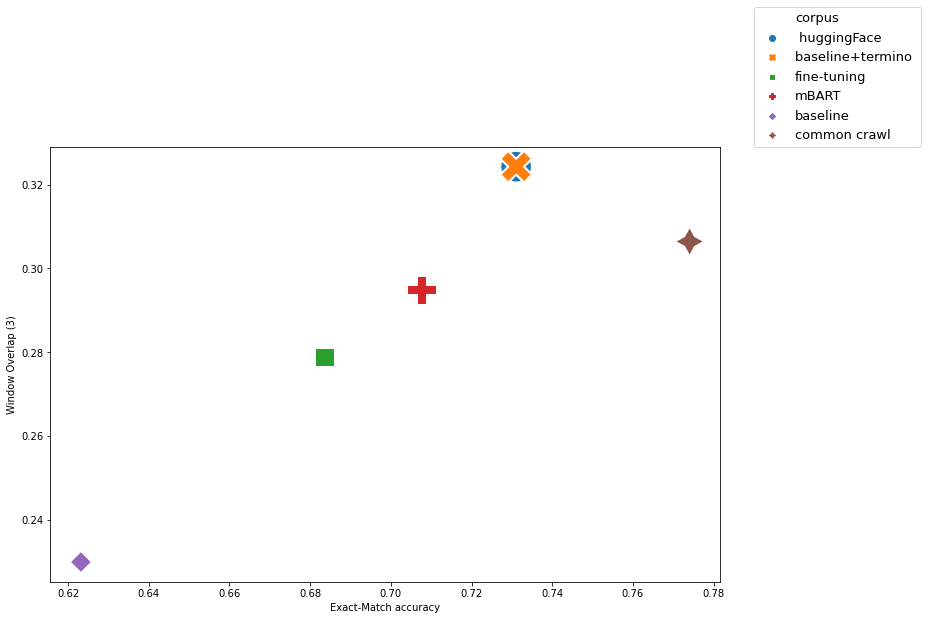

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
import seaborn as sns
sns.color_palette("rocket", as_cmap=True)
g=sns.scatterplot(data=df, x="Exact-Match accuracy", y="Window Overlap (3)", hue="corpus", style='corpus', size="Window Overlap (3)", sizes=(500, 1000))
h,l = g.get_legend_handles_labels()
plt.legend(h[0:7],l[0:7],bbox_to_anchor=(1.05, 1), loc="lower left", borderaxespad=0., fontsize=13)
plt.savefig('graphic.png')

### comparison of the two estimations

In [50]:
exact_match_accuracy = [0.7740524781341108, 0.7310495626822158, 0.6231778425655977, 	0.871, 	0.795, 	0.640]
window_overlap_accuracy = [0.3064261418853255, 0.32429543245869774, 0.22984693877551018, 	0.296, 	0.267, 	0.241]
corpus = ['common crawl', 'baseline+termo', 'baseline', 'common crawl', 'baseline+termo', 'baseline']
estimation = ['our estimation', 'our estimation', 'our estimation', 'official estimation', 'official estimation', 'official estimation']
df = pd.DataFrame({'Exact-Match accuracy': exact_match_accuracy, 'Window Overlap (3)':window_overlap_accuracy, 'corpus': corpus, 'estimation': estimation})

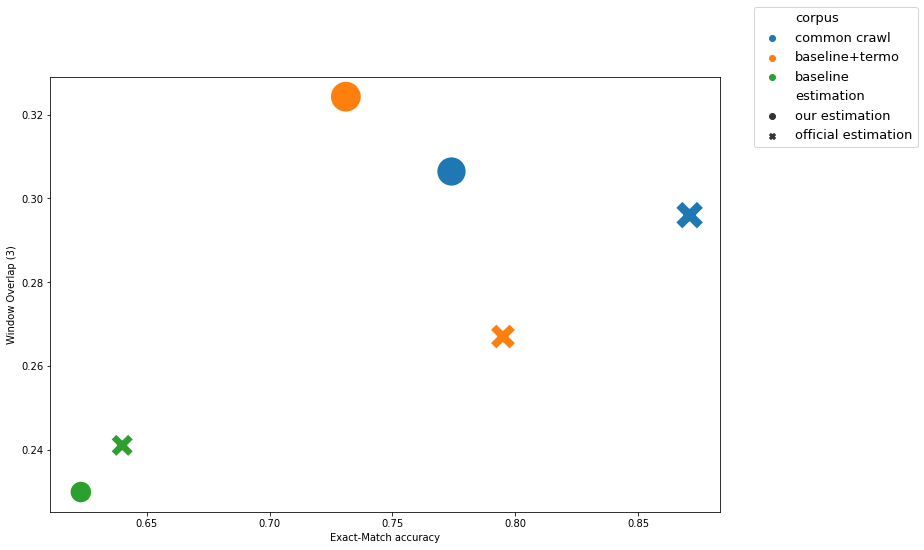

In [63]:
plt.figure(figsize=(12,8))

g=sns.scatterplot(data=df, x="Exact-Match accuracy", y="Window Overlap (3)", hue="corpus", style="estimation", size="Window Overlap (3)", sizes=(500, 1000))
h,l = g.get_legend_handles_labels()
plt.legend([h[0], h[1], h[2], h[3], h[11], h[12], h[13]],[l[0], l[1], l[2], l[3], l[11], l[12], l[13]],bbox_to_anchor=(1.05, 1), loc="center left", borderaxespad=0., fontsize=13)
plt.show()

### comparison between fine-tunning and common crawl

In [68]:
fine_tunning = [df3.iloc[:,7].values.mean(), df3.iloc[:,8].values.mean(), df3.iloc[:,9].values.mean(), df3.iloc[:,10].values.mean(), df3.iloc[:,11].values.mean(), df3.iloc[:,12].values.mean()]
common_crawl = [df6.iloc[:,7].values.mean(), df6.iloc[:,8].values.mean(), df6.iloc[:,9].values.mean(), df6.iloc[:,10].values.mean(), df6.iloc[:,11].values.mean(), df6.iloc[:,12].values.mean()]
scores = ['sacrebleu', 'exact-match accuracy', 'window overlap (2)', 'window overlap (3)', '1-TER', '1-TERm']
df = pd.DataFrame({'scores': scores,'fine tunning':fine_tunning, 'common crawl': common_crawl})

In [69]:
df

,scores,fine tunning,common crawl
0,sacrebleu,26.190324,28.500017
1,exact-match accuracy,0.683673,0.774052
2,window overlap (2),0.279519,0.299563
3,window overlap (3),0.278754,0.306426
4,1-TER,0.287201,0.308962
5,1-TERm,0.278330,0.300921
